# Python for Data Science - Final Project - Team 4
## Performance Analysis of Fast Food Companies in the Stock Market

### Getting Started
This notebook is designed to provide a structured approach to exploring and analyzing the datasets of 10 major fast-food companies.
Each dataset contains daily stock market data with information on opening price, closing price, trading volume, and other financial metrics.

### Objective
The primary goal of this notebook is to perform a comprehensive analysis of the stock market performance of these companies over the years. Through this analysis, we aim to:

1. Understand the structure and content of the datasets
2. Explore key metrics such as price trends, trading volumees, and price spreads
3. Visualize and interrupt important patterns and relationships in the data
4. Summarize insights that reveal the financial dynamics of the fast-food industry

### Dataset Overview
The datasets include the following companies:

- BRK-A: Berkshire Hathaway Inc.
- DNUT: Krispy Kreme, Inc.
- DPZ: Domino’s Pizza, Inc.
- LKNCY: Luckin Coffee Inc.
- MCD: McDonald’s Corporation
- PZZA: Papa John’s International, Inc.
- QSR: Restaurant Brands International, Inc.
- SBUX: Starbucks Corporation
- WEN: The Wendy’s Corporation
- YUM: Yum! Brands, Inc.

Each dataset contains the following columns:

- *Date*: Trading date.
- *Open*: Opening price.
- *High*: Highest price during the session.
- *Low*: Lowest price during the session.
- *Close*: Closing price.
- *Adj Close*: Adjusted closing price (accounting for dividends and stock splits).
- *Volume*: Number of shares traded during the session.

---

# Data Preprocessing Summary

## Preprocessing Steps

1. **Missing Volume Handling**:
   - Replaced missing values in the `Volume` column using a 7-day rolling mean.

2. **Missing Values Imputation**:
   - For columns `['Open', 'High', 'Low', 'Close', 'Adj Close']`:
     - Replaced outliers (Z-score > 3 or < -3) with the rolling median (7-day window).
     - Imputed any remaining missing values using the rolling median.

3. **Erroneous Values Correction**:
   - Checked for rows where `Low >= High`:
     - Replaced `Low` values with a 7-day rolling mean.
     - Ensured that `Low` values do not exceed corresponding `High` values by adjusting `Low` to equal `High` where necessary.

4. **Zero Volume Handling**:
   - For rows where `Volume == 0`:
     - If price columns (`['Open', 'High', 'Low', 'Close']`) had different values, replaced them with the mode (most common value).

5. **Uniform Price Handling**:
   - Identified rows where all price columns (`['Open', 'High', 'Low', 'Close']`) were identical:
     - If `Volume` was NaN, replaced it with `0.0`.

6. **Duplicate Dates Check**:
   - Checked for duplicate dates in the `Date` column:
     - Reported the count of duplicates and displayed duplicate rows if found.
     - If no duplicates, confirmed the absence of duplicate dates.

7. **Output**:
   - Saved the cleaned DataFrame for each ticker into a dictionary (`dfs`) for further analysis.

## Key Points
- Used rolling statistics (mean and median) for robust handling of missing values and outliers.
- Ensured consistency in `Low` and `High` values.
- Imputed `Volume` as `0.0` for rows with identical price columns and missing volume.


In [6]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

# Adding the files into a list
files=['Team_4/BRK-A.csv',
       'Team_4/DNUT.csv',
       'Team_4/DPZ.csv',
       'Team_4/LKNCY.csv',
       'Team_4/MCD.csv',
       'Team_4/PZZA.csv',
       'Team_4/QSR.csv',
       'Team_4/SBUX.csv',
       'Team_4/WEN.csv',
       'Team_4/YUM.csv']

i=0

# Step 1: Create a list to store the DataFrames
dfs = {}
tickers = ['BRK-A', 'DNUT', 'DPZ', 'LKNCY', 'MCD', 'PZZA', 'QSR', 'SBUX', 'WEN', 'YUM']

for ticker, file in zip(tickers, files):

    # Step 1: Load the dataset
    df = pd.read_csv(file, index_col=False)

    print(df.isnull().sum())

    print('initialdataset',df.head(16))

    # Handling Missing Volume
    df['Volume'] =df['Volume'].fillna(df['Volume'].rolling(window=7, min_periods=1).mean())

    
    # Impute missing values for each column using rolling mean
    columns_to_impute = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    # Handling Outliers
    for column in columns_to_impute:
        # Calculate mean and standard deviation
        mean = df[column].mean()
        std_dev = df[column].std()

        # Calculate Z-scores
        z_scores = (df[column] - mean) / std_dev

        # Identify outlier indices (Z-score > 3 or < -3)
        outlier_indices = df[np.abs(z_scores) > 3].index

        # Replace outliers with the rolling median
        for idx in outlier_indices:
            df.at[idx, column] = df[column].rolling(window=7, min_periods=1).median().iloc[idx]

        # Fill any remaining missing values with rolling median
        df[column] = df[column].fillna(df[column].rolling(window=7, min_periods=1).median())

   

    
    # Step 1: Check for rows where Low >= High
    erroneous_rows = df['Low'] >= df['High']

    # Step 2: Replace erroneous values with the column's average
    low_avg = df['Low'].rolling(window=7, min_periods=1).mean()
    
    df.loc[erroneous_rows, 'Low'] = low_avg
    #INCLUDE IF AVERAGE OF LOW IS HIGHER THAN HIGH VALUE, THEN REPLCAE THE LOW WITH THE HIGH VALUE SO THEY ARE THE SAME

    # Step 1: Identify rows where Volume == 0
    volume_zero_rows = df['Volume'] == 0

    # Step 2: Apply the logic to each row where Volume is 0
    for index, row in df[volume_zero_rows].iterrows():
        # Step 3: Check if any of Open, High, Low, or Close are different
        values = ['Open', 'High', 'Low', 'Close']
        values_dict = row[values]

        # If any value is different, replace it with the common value
        unique_values = values_dict.unique()
        if len(unique_values) > 1:  # More than one unique value means there is a difference
            common_value = values_dict.mode()[0]  # Find the most common value
            for col in values:
                if row[col] != common_value:
                    df.at[index, col] = common_value  # Replace with the common value


    # Step 1: Identify rows where all price columns are the same
    price_columns = ['Open', 'High', 'Low', 'Close']
    price_same_rows = (df[price_columns].nunique(axis=1) == 1)  # Check if all values are the same across price columns

    # Step 2: Check if Volume is NaN for those rows
    volume_empty_rows = price_same_rows & df['Volume'].isna()

    # Step 3: Replace NaN Volume with 0.0 (in float) for those rows
    df.loc[volume_empty_rows, 'Volume'] = 0.0
  

    print('Finaldataset',df.head(16))

    # Check for duplicate dates
    if 'Date' in df.columns:
        duplicate_dates = df['Date'].duplicated().sum()
        if duplicate_dates > 0:
            print(f"There are {duplicate_dates} duplicate date(s).")
            print("Duplicate rows:")
            print(df[df['Date'].duplicated(keep=False)])
        else:
            print("No duplicate dates found.")
    else:
        print("The column 'Date' does not exist in the DataFrame.")

    dfs[ticker]=df
 

Date           0
Open         548
High         550
Low          550
Close        550
Adj Close    544
Volume       561
dtype: int64
initialdataset           Date   Open          High           Low  Close     Adj Close  \
0   1980-03-17  290.0  3.100000e+02  2.900000e+02  290.0  2.900000e+02   
1   1980-03-18  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
2   1980-03-19  290.0  3.100000e+02  2.900000e+02  290.0  2.900000e+02   
3   1980-03-20  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
4   1980-03-21  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
5   1980-03-24  290.0  2.900000e+02  2.700000e+02  270.0           NaN   
6   1980-03-25  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
7   1980-03-26  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
8   1980-03-27  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
9   1980-03-28  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
10  1980-03-31  270.0  2.800000e+02  2.

# **EXERCISE 1**  
---
**For Each Dataset**  
- **Print the number of rows and columns**  
- **Display the column names and their data types**  
🎉


In [7]:
import pandas as pd

summary = []

for ticker, df in dfs.items():
    print(f"--- Processing Dataset for {ticker} ---")
    
    num_rows, num_cols = df.shape
    
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_cols}\n")
    
    print("Column Names and Data Types:")
    for col, dtype in df.dtypes.items():
        print(f"{col}: {dtype}")
    
    print("\n") 
    
    summary.append({
        'Ticker': ticker,
        'Rows': num_rows,
        'Columns': num_cols,
        'Column Info': df.dtypes.to_dict()
    })

summary_df = pd.DataFrame(summary)

summary_df.to_csv('dataset_summary.csv', index=False)

print("Summary of all datasets:")
print(summary_df)


--- Processing Dataset for BRK-A ---
Number of rows: 11227
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: float64
Low: float64
Close: float64
Adj Close: float64
Volume: float64


--- Processing Dataset for DNUT ---
Number of rows: 815
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: float64
Low: float64
Close: float64
Adj Close: float64
Volume: float64


--- Processing Dataset for DPZ ---
Number of rows: 5088
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: float64
Low: float64
Close: float64
Adj Close: float64
Volume: float64


--- Processing Dataset for LKNCY ---
Number of rows: 1350
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: float64
Low: float64
Close: float64
Adj Close: float64
Volume: float64


--- Processing Dataset for MCD ---
Number of rows: 14657
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: fl

# **EXERCISE 2**  
---

### Extract Rows for 2023
- **Filter all rows where the date is in the year 2023**  
- **Print the number of rows**  
- **Visualize the Close price trend for this period**  
🎉


--- Processing Dataset for BRK-A ---
Number of rows for 2023: 250


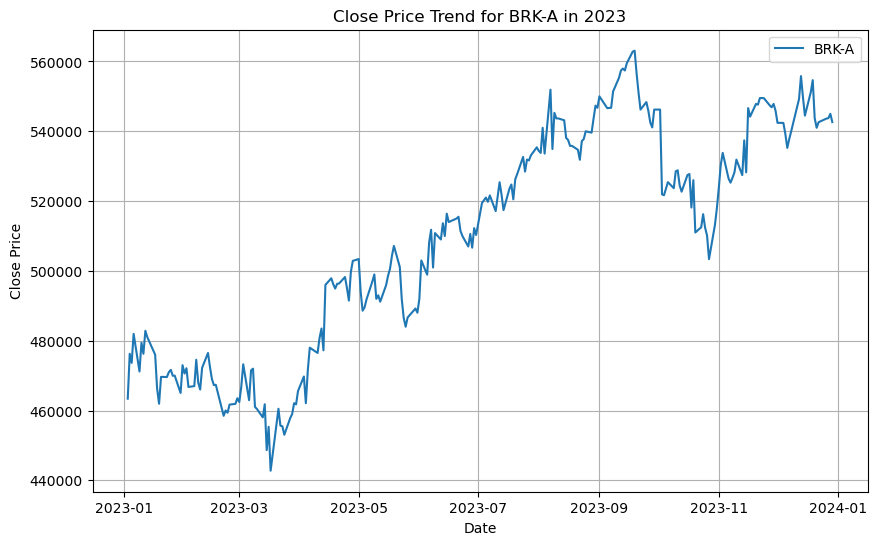



--- Processing Dataset for DNUT ---
Number of rows for 2023: 252


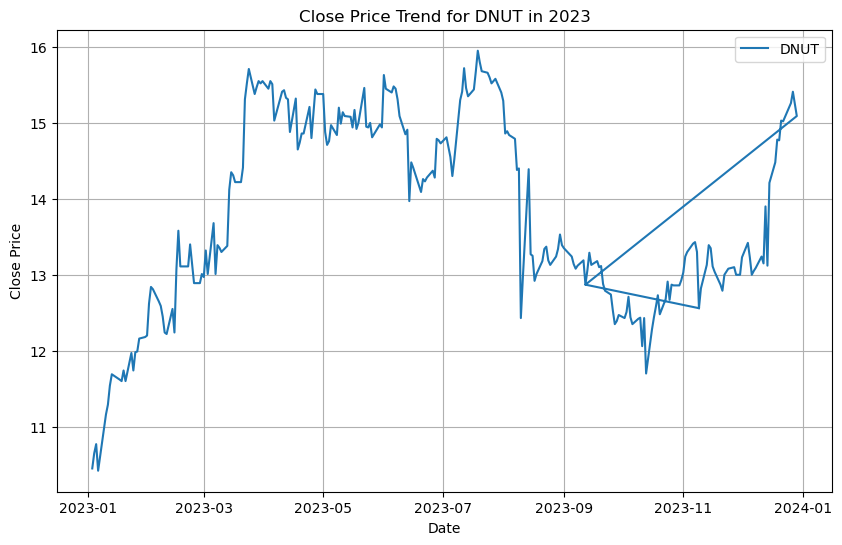



--- Processing Dataset for DPZ ---
Number of rows for 2023: 250


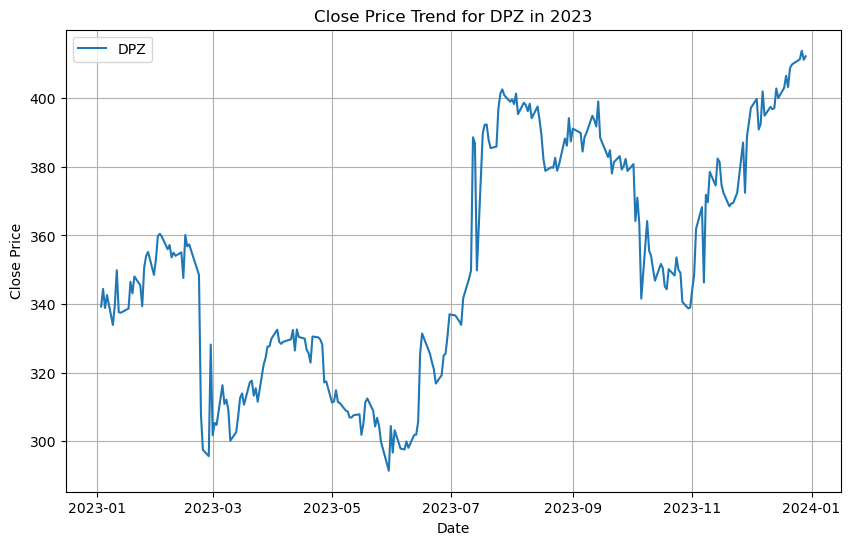



--- Processing Dataset for LKNCY ---
Number of rows for 2023: 251


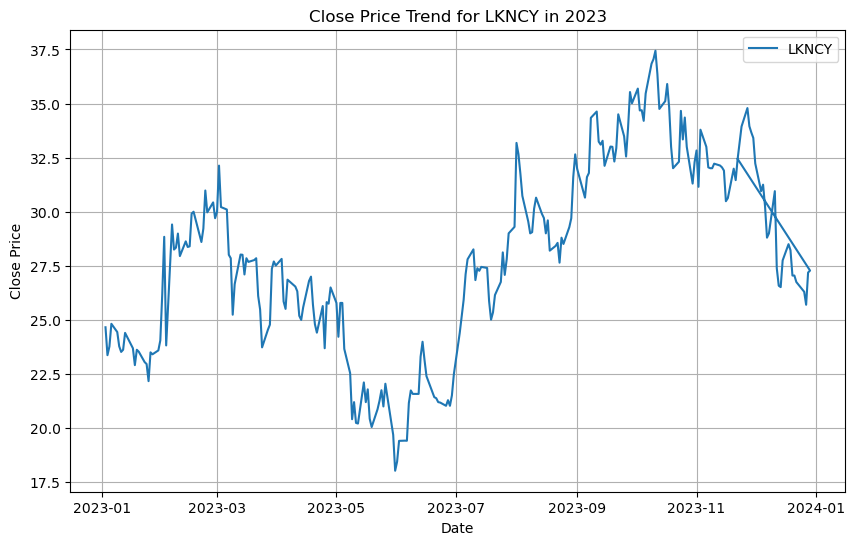



--- Processing Dataset for MCD ---
Number of rows for 2023: 250


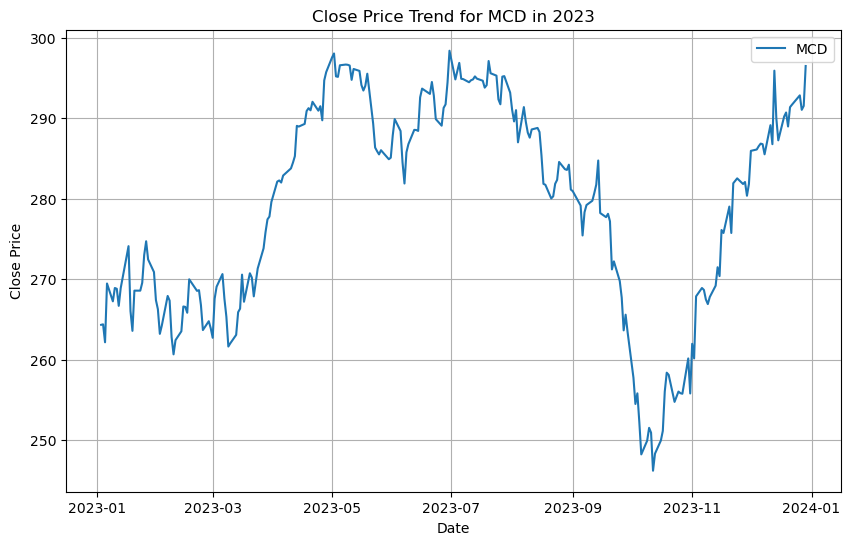



--- Processing Dataset for PZZA ---
Number of rows for 2023: 250


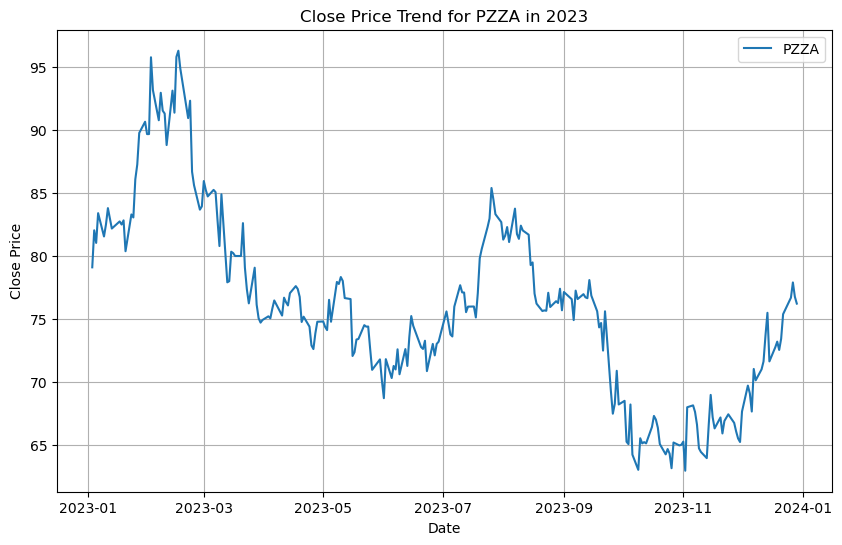



--- Processing Dataset for QSR ---
Number of rows for 2023: 250


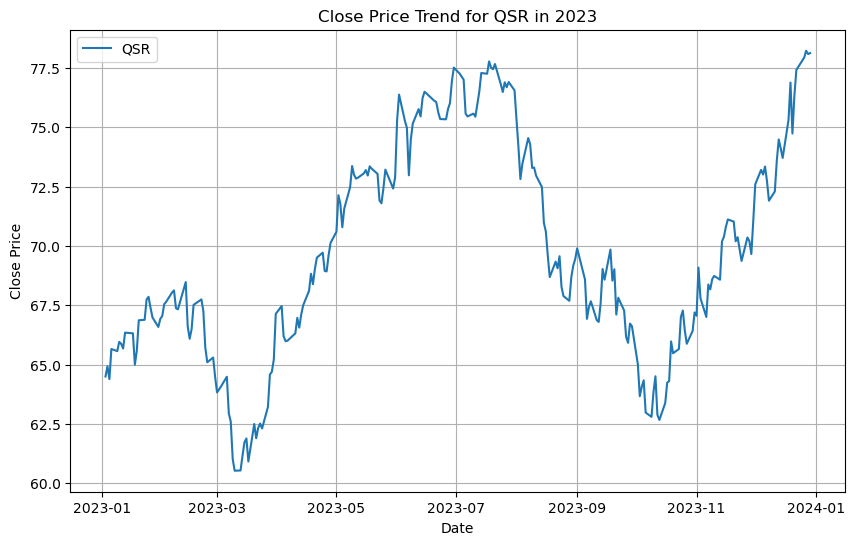



--- Processing Dataset for SBUX ---
Number of rows for 2023: 250


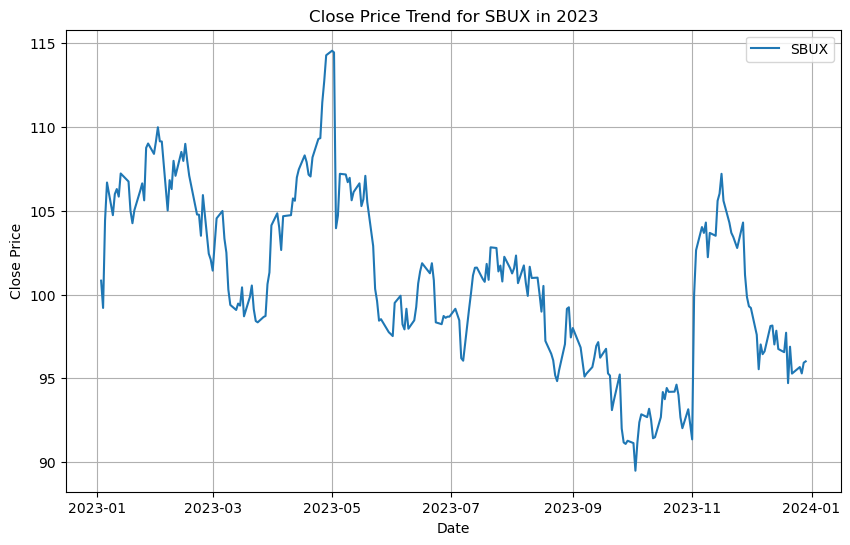



--- Processing Dataset for WEN ---
Number of rows for 2023: 251


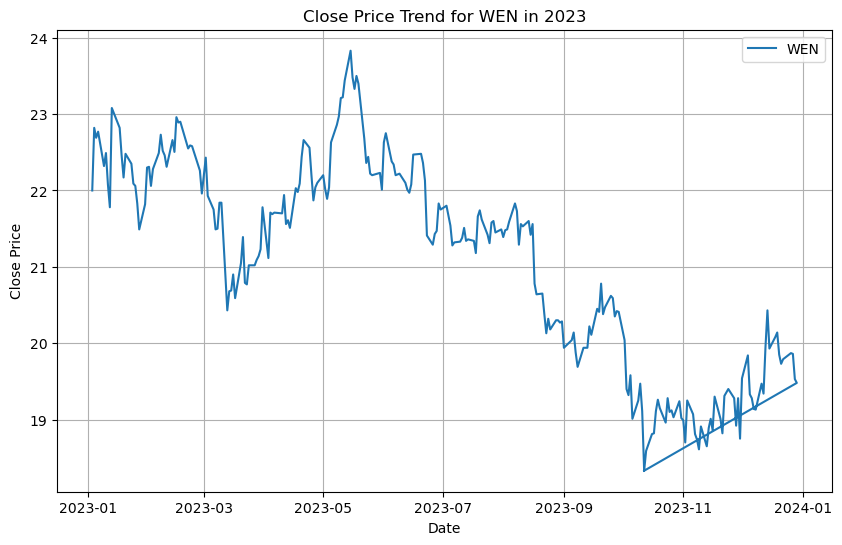



--- Processing Dataset for YUM ---
Number of rows for 2023: 250


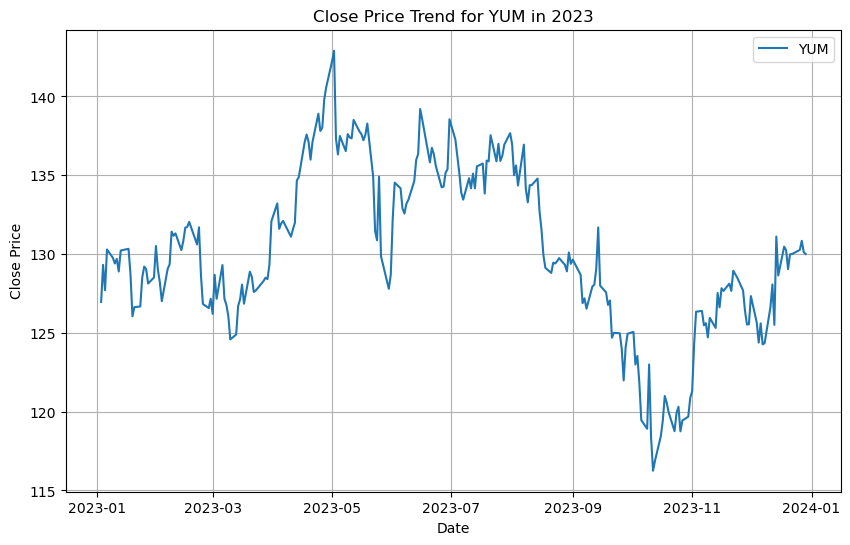

In [9]:
import matplotlib.pyplot as plt

for ticker, df in dfs.items():
    print(f"--- Processing Dataset for {ticker} ---")
    
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        print(f"'Date' column not found in {ticker}. Skipping...")
        continue
    
    df_2023 = df[df['Date'].dt.year == 2023]
    
    num_rows_2023 = len(df_2023)
    print(f"Number of rows for 2023: {num_rows_2023}")
    
    if num_rows_2023 == 0:
        print(f"No data for 2023 in {ticker}. Skipping visualization...")
        continue
    
    # Visualize the Close price trend for 2023
    if 'Close' in df_2023.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(df_2023['Date'], df_2023['Close'], label=ticker)
        plt.title(f"Close Price Trend for {ticker} in 2023")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print(f"'Close' column not found in {ticker}. Skipping visualization...")
    
    print("\n")


# **EXERCISE 3**  
---

**Find the Day with Highest Close Price**  
- **For each company, identify the day with the highest Close price**  
- **Display the date and the corresponding Close price**  
🎉


In [14]:
for ticker, df in dfs.items():
    print(f"--- Processing Dataset for {ticker} ---")
    
    if 'Date' in df.columns and 'Close' in df.columns:
        max_close_row = df.loc[df['Close'].idxmax()]
        
        highest_close_date = max_close_row['Date']
        highest_close_price = max_close_row['Close']
        
        display(f"Highest Close Price for {ticker}:")
        display(f"Date: {highest_close_date}, Close Price: {highest_close_price}")
    else:
        display(f"Required columns ('Date' and/or 'Close') not found in {ticker}. Skipping...")


--- Processing Dataset for BRK-A ---


'Highest Close Price for BRK-A:'

'Date: 2024-09-03 00:00:00, Close Price: 715910.0'

--- Processing Dataset for DNUT ---


'Highest Close Price for DNUT:'

'Date: 2021-07-01 00:00:00, Close Price: 21.0'

--- Processing Dataset for DPZ ---


'Highest Close Price for DPZ:'

'Date: 2021-12-31 00:00:00, Close Price: 564.3300170898438'

--- Processing Dataset for LKNCY ---


'Highest Close Price for LKNCY:'

'Date: 2020-01-16 00:00:00, Close Price: 48.52999877929688'

--- Processing Dataset for MCD ---


'Highest Close Price for MCD:'

'Date: 2024-01-19 00:00:00, Close Price: 300.5299987792969'

--- Processing Dataset for PZZA ---


'Highest Close Price for PZZA:'

'Date: 2021-11-04 00:00:00, Close Price: 140.00999450683594'

--- Processing Dataset for QSR ---


'Highest Close Price for QSR:'

'Date: 2024-03-13 00:00:00, Close Price: 82.75'

--- Processing Dataset for SBUX ---


'Highest Close Price for SBUX:'

'Date: 2021-07-26 00:00:00, Close Price: 126.05999755859376'

--- Processing Dataset for WEN ---


'Highest Close Price for WEN:'

'Date: 1980-05-07 00:00:00, Close Price: 63.3963421596517'

--- Processing Dataset for YUM ---


'Highest Close Price for YUM:'

'Date: 2023-05-02 00:00:00, Close Price: 142.89999389648438'

# **EXERCISE 4**  
---

### **Monthly Average Close Price Analysis**  
- **Group the data by month and calculate the average Close price for each company**  
- **Plot these monthly averages for 3 companies and compare them**  
- **Justify the chart selection**  
🎉


--- Processing Dataset for BRK-A ---
--- Processing Dataset for DNUT ---
--- Processing Dataset for DPZ ---
--- Processing Dataset for LKNCY ---
--- Processing Dataset for MCD ---
--- Processing Dataset for PZZA ---
--- Processing Dataset for QSR ---
--- Processing Dataset for SBUX ---
--- Processing Dataset for WEN ---
--- Processing Dataset for YUM ---


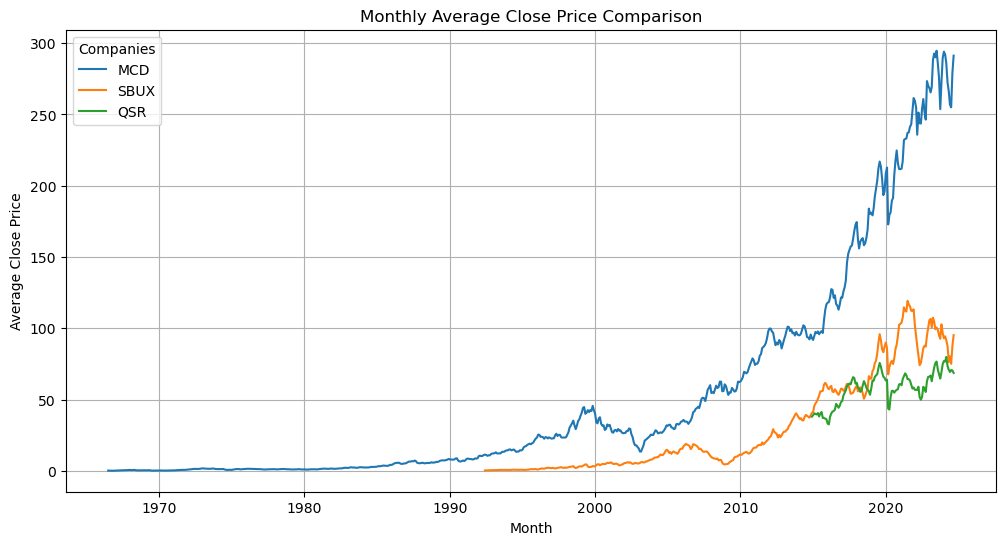

In [17]:
monthly_averages = {}

for ticker, df in dfs.items():
    print(f"--- Processing Dataset for {ticker} ---")
    
    if 'Date' in df.columns and 'Close' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df['YearMonth'] = df['Date'].dt.to_period('M')
        monthly_avg = df.groupby('YearMonth')['Close'].mean()
        monthly_averages[ticker] = monthly_avg
    else:
        print(f"Required columns ('Date' and/or 'Close') not found in {ticker}. Skipping...\n")

# Plot monthly average Close prices for 3 companies
selected_tickers = ['MCD', 'SBUX', 'QSR']

plt.figure(figsize=(12, 6))

for ticker in selected_tickers:
    if ticker in monthly_averages:
        plt.plot(monthly_averages[ticker].index.to_timestamp(), monthly_averages[ticker], label=ticker)

plt.title("Monthly Average Close Price Comparison")
plt.xlabel("Month")
plt.ylabel("Average Close Price")
plt.legend(title="Companies")
plt.grid(True)
plt.show()



Why we slected the line char:

Becaue the line chart effectively shows trends over time. It helps us clearly see how the monthly average Close prices change over time for the three companies. By connecting the data points, it shows trends and patterns, like steady growth, sudden spikes, or seasonal dips, making it easier to interpret the performance.

Since we’re comparing three companies, the line chart works well because it can display multiple datasets on the same plot without looking cluttered. Each company has its own line, so we can easily spot differences, similarities, and how they behave over time. A bar chart or scatter plot wouldn’t work as effectively here. The line chart emphasizes the flow of time and lets us quickly understand how prices progress from month to month, which is the key focus of this exercise.